In [1]:
# Libraries:
import numpy as np
import matplotlib.pyplot as plt
import dill
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..'))) # include parent directory in the path
from data import SINDy_data
from data import data
from data import equations

sys.path.append("/home/mattg/D_CODE") # A questo punto è necessario per non doverlo chiamare i file che usano D_CODE.
from toolbox.auxiliary_functions import set_param_freq
from toolbox.symbolic_SINDy import symbolic_SINDy

# Seed:
np.random.seed(999)

/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


#### Case $n$, $k$, $k_a$ and $k_y$ fixed
Consider the modified Van der Pol system with a nonlinear forcing term
$$
\begin{cases}
\dot{x} = \frac{k y^n}{k_a + y^n} \\
\dot{y} = - k_y y
\end{cases}
$$
and with $n=2.8$, $k=1$, $k_a=4$ and $k_y=0.1$ fixed fixed.

In [2]:
# Select ODE & settings:
ode_name = 'HillODE' # help="name of the ode", type=str
ode_param = '2.8,1,4,0.1' # help="parameters of the ode (default: None)", type=str, default=None
freq = 10 # help="sampling frequency", type=float, default=10
freq_SR = 10
n_sample = 50 # help="number of trajectories", type=int, default=100
noise_ratio = 0.01 # help="noise level (default 0)", type=float, default=0.
seed = 100 # help="random seed", type=int, default=0
n_seed = 1 # help="random seed", type=int, default=10

ode_param, freq = set_param_freq(ode_param, freq)

ode = equations.get_ode(ode_name, ode_param)
dt = 1 / freq
dim_x = 2
dim_k = 0
time_vector = np.arange(0, ode.T + dt, dt)
T = ode.T

In [3]:
# # Generate data:
# X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_ratio, dim_x, dim_k)
# print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
# print(feature_names)

# # Save data:
# file_path = 'saved/data/hillODE_data.pkl'
# os.makedirs(os.path.dirname(file_path), exist_ok=True)
# with open(file_path, 'wb') as f:
#     dill.dump((X_list, dX_list, param_list, feature_names), f)

In [4]:
# Uploda data:
file_path = 'saved/data/hillODE_data.pkl'
with open(file_path, 'rb') as f:
    X_list, dX_list, param_list, feature_names = dill.load(f)

print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

(50, 150, 2) (50, 150, 2) (0,)
['X0', 'X1']


In [7]:
# Symbolic-SINDy call and fit
model = symbolic_SINDy(SR_method='D-CODE', 
                       x_id=0,
                       degree=3,
                       threshold=0.05,
                       product=True)
final_model, building_blocks_lambda, _, _, _, _ =  model.call(X_list=X_list, dX_list=dX_list, param_list=param_list,
           feature_names=feature_names, dt=dt, building_blocks_lambda=None, 
           function_names=None, patience=0, lazy=True, ode=ode, ode_name=ode_name,
           ode_param=ode_param, freq_SR=freq_SR, n_sample=n_sample, 
           noise_ratio=noise_ratio, seed=seed, n_seed=n_seed, 
           T0=0, T=T, dim_x=dim_x, dim_k=dim_k)


Searching for the best building block:
Model:
(X0)' = 0.295 X1 2.3057066204788934/X1
(X1)' = 0.000


/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(
/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(
/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(
/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(


Model:
(X0)' = 0.751 X1 + 0.030 X0 X1 + 10.683 X1^2 + 0.006 X0 X1^2 + 1.194 X1^3 + -1.609 X1**1.1013776114729934 + -0.030 X0 X1**1.1013776114729934 + -10.034 X1 X1**1.1013776114729934 + -0.004 X0 X1 X1**1.1013776114729934 + -0.777 X1^2 X1**1.1013776114729934
(X1)' = 0.000
Model:
(X0)' = 0.286 1 + 0.127 X1
(X1)' = -0.100 X1
Model:
(X0)' = -0.810 X1 + -5.750 X1^2 + -0.386 X1^3 + 6.372 X1**1.8296412225724046 + 0.799 X1 X1**1.8296412225724046
(X1)' = -0.100 X1


/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(
/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(


Model:
(X0)' = 2.151 1 + 5.989 X1 + 0.083 X1^2 + -1.086 X1^2 3.380613970691187*X1**(-1.8296412225724046) + -1.276 X1^3 3.380613970691187*X1**(-1.8296412225724046)
(X1)' = 0.000
Model:
(X0)' = 0.192 X1
(X1)' = -0.100 X1


/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(
/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(


Model:
(X0)' = 1.825 X1 + 0.064 X1^2 + -0.207 X1^2 3.380613970691187*X1**(-1.61820675623109) + -0.270 X1^3 3.380613970691187*X1**(-1.61820675623109)
(X1)' = 0.000
Model:
(X0)' = -1.177 X1 + -2.917 X1^2 + -0.118 X1^3 + 3.803 X1**1.61820675623109 + 0.638 X1 X1**1.61820675623109
(X1)' = -0.100 X1


/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(
/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(


Model:
(X0)' = -2.122 1 + -0.261 X1 + 0.067 X1 3.380613970691187*X1**(-1.641245736232466) + 0.719 X1^2 3.380613970691187*X1**(-1.641245736232466)
(X1)' = 0.000
Model:
(X0)' = -1.127 X1 + -3.054 X1^2 + -0.131 X1^3 + 3.905 X1**1.641245736232466 + 0.635 X1 X1**1.641245736232466
(X1)' = -0.100 X1
Model:
(X0)' = -1.204 X1 + -2.856 X1^2 + -0.112 X1^3 + 3.761 X1**1.6068299625363338 + 0.640 X1 X1**1.6068299625363338
(X1)' = -0.100 X1


/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(
/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(


Model:
(X0)' = 1.834 X1 + 0.068 X1^2 + -0.213 X1^2 3.380613970691187*X1**(-1.6068299625363338) + -0.268 X1^3 3.380613970691187*X1**(-1.6068299625363338)
(X1)' = 0.000
Model:
(X0)' = -0.133 1 + 0.424 X1 + -0.079 X1^3 + 0.061 X1**3.1000620005467505
(X1)' = -0.100 X1
Model:
(X0)' = -1.168 X1 + -2.939 X1^2 + -0.120 X1^3 + 3.819 X1**1.6221502493520694 + 0.637 X1 X1**1.6221502493520694
(X1)' = -0.100 X1


/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(
/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(


Model:
(X0)' = 1.823 X1 + 0.062 X1^2 + -0.205 X1^2 3.380613970691187*X1**(-1.6221502493520694) + -0.271 X1^3 3.380613970691187*X1**(-1.6221502493520694)
(X1)' = 0.000
Model:
(X0)' = -1.046 X1 + -3.350 X1^2 + -0.159 X1^3 + 4.144 X1**1.6816160031652045 + 0.638 X1 X1**1.6816160031652045
(X1)' = -0.100 X1


/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(
/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(


Model:
(X0)' = -0.854 1 + -0.073 X1 + 0.384 X1^2 3.380613970691187*X1**(-1.6816160031652045)
(X1)' = 0.000


/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(
/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(


Model:
(X0)' = 0.184 1 + 1.451 X1 + -0.147 X1^2 3.8382850685339953*X1**(-1.7804891870145587) + -0.206 X1^3 3.8382850685339953*X1**(-1.7804891870145587)
(X1)' = 0.000
Model:
(X0)' = 0.154 X1 + 0.067 X1^3 + 0.185 X1**1.7804891870145587 + -0.130 X1 X1**1.7804891870145587
(X1)' = -0.100 X1
Model:
(X0)' = 0.997 X1 1/(3.8382850685339953*X1**(-1.7804891870145587) + X1)
(X1)' = -0.100 X1
errors:  [9.011147639968256, 1000, 1.1537000545301674, 0.1453132981408042, 4.650621012763849, 0.3313133294204002, 4.616754032006895, 0.09233448649090982, 4.781151282020813, 0.09410713228486699, 0.09164046982184773, 4.614202987402952, 0.09943036751840556, 0.09260206625371567, 4.617624402384334, 0.09859584069235311, 5.431520751175179, 4.375727953653926, 0.07895857364753817, 0.011504248060845625]

Best building block:
['1/(3.8382850685339953*X1**(-1.7804891870145587) + X1)']

Smart-SINDy model:
(X0)' = 0.997 X1 1/(3.8382850685339953*X1**(-1.7804891870145587) + X1)
(X1)' = -0.100 X1
Model complexity:  2
Lasso pena

##### Plot per report

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def evaluate_traj(model, ode, freq, n_sample, init_high, init_low,
                  dim_x=1, dim_k=1, title=None, T_aux=100):

    np.random.seed(666)
    dt = 1 / freq
    time_vector = np.arange(0, T_aux, dt)
    t = np.arange(0, T_aux, dt)
    T_plot = len(t)

    # true trajectories:
    dg_true = data.DataGenerator(ode, T_aux, freq, n_sample,
                                 noise_sigma=0., init_high=init_high, init_low=init_low)
    xt_true = dg_true.xt

    # estimated trajectories:
    pred_0_list = []
    for i in range(n_sample):
        correct_param = xt_true[0, i, -dim_k:]
        t = np.arange(0, T_aux, dt)
        T_plot = len(t)
        test_params = np.tile(correct_param, (T_plot, 1))
        if dim_k != 0:
            pred_0 = model.simulate(xt_true[0, i, :][:-dim_k], t=t[:T_plot], u=test_params)
        else:
            pred_0 = model.simulate(xt_true[0, i, :], t=t[:T_plot])
        pred_0_list.append(pred_0)

    # reshape
    xt_true = xt_true[:len(pred_0), :, :]
    time_vector = time_vector[:len(pred_0)]
    if dim_k != 0:
        xt_true = xt_true[:, :, :-dim_k]
    xt_true = xt_true.squeeze()
    pred_0_list = np.transpose(pred_0_list, (1, 0, 2)).squeeze()

    # ------------ PLOTTING ------------
    if n_sample == 1:

        # -------- dim_x = 1 ----------
        if dim_x == 1:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4))
            ax.plot(time_vector, pred_0_list, color='blue', linewidth=1.0,
                    alpha=0.7, label=r'Estimated Trajectory')
            ax.plot(time_vector, xt_true, color='red', linewidth=1.0,
                    linestyle='--', label=r'Correct Trajectory')
            ax.scatter(time_vector[0], xt_true[0], color='green', label=r'Start')
            ax.scatter(time_vector[-1], xt_true[-1], color='red', label=r'End')
            ax.set_xlabel(r'$t$')
            ax.set_ylabel(r'$x$')
            if title:
                ax.set_title(r'%s' % title)
            ax.legend(fontsize=9, loc='lower right')
            ax.grid(True)

        # -------- dim_x = 2 (RISCRITTO) ----------
        elif dim_x == 2:

            fig, axes = plt.subplots(2, 1, figsize=(5, 6), sharex=True)

            # ----- PLOT x(t) -----
            axes[0].plot(time_vector, pred_0_list[:, 0], color='blue',
                        linewidth=1.0, alpha=0.7, label=r'Estimated $x(t)$')
            axes[0].plot(time_vector, xt_true[:, 0], color='red',
                        linewidth=1.0, linestyle='--', label=r'Correct $x(t)$')

            # Start & End sulla traiettoria vera
            axes[0].scatter(time_vector[0], xt_true[0, 0], color='green', label='Start')
            axes[0].scatter(time_vector[-1], xt_true[-1, 0], color='red', label='End')

            axes[0].set_ylabel(r'$x(t)$')
            axes[0].legend(fontsize=9)
            axes[0].grid(True)

            # ----- PLOT y(t) -----
            axes[1].plot(time_vector, pred_0_list[:, 1], color='blue',
                        linewidth=1.0, alpha=0.7, label=r'Estimated $y(t)$')
            axes[1].plot(time_vector, xt_true[:, 1], color='red',
                        linewidth=1.0, linestyle='--', label=r'Correct $y(t)$')

            # Start & End sulla traiettoria vera
            axes[1].scatter(time_vector[0], xt_true[0, 1], color='green', label='Start')
            axes[1].scatter(time_vector[-1], xt_true[-1, 1], color='red', label='End')

            axes[1].set_xlabel(r'$t$')
            axes[1].set_ylabel(r'$y(t)$')
            axes[1].legend(fontsize=9)
            axes[1].grid(True)

            if title:
                fig.suptitle(r'%s' % title)

            fig.tight_layout()


        # -------- dim_x = 3 ----------
        else:
            fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': '3d'})
            ax.plot(pred_0_list[:, 0], pred_0_list[:, 1], pred_0_list[:, 2],
                    color='blue', linewidth=1.0, alpha=0.7, label=r'Estimated Trajectory')
            ax.plot(xt_true[:, 0], xt_true[:, 1], xt_true[:, 2],
                    color='red', linewidth=1.0, linestyle='--', label=r'Correct Trajectory')
            ax.scatter(xt_true[:, 0][0], xt_true[:, 1][0], xt_true[:, 2][0], color='green', label=r'Start')
            ax.scatter(xt_true[:, 0][-1], xt_true[:, 1][-1], xt_true[:, 2][-1], color='red', label=r'End')
            ax.set_xlabel(r'$x$')
            ax.set_ylabel(r'$y$')
            ax.set_zlabel(r'$z$')
            if title:
                ax.set_title(r'%s' % title)
            ax.legend(fontsize=9, loc='lower right')
            ax.grid(True)


Best SINDy Model RMSE:  0.01421806826744626


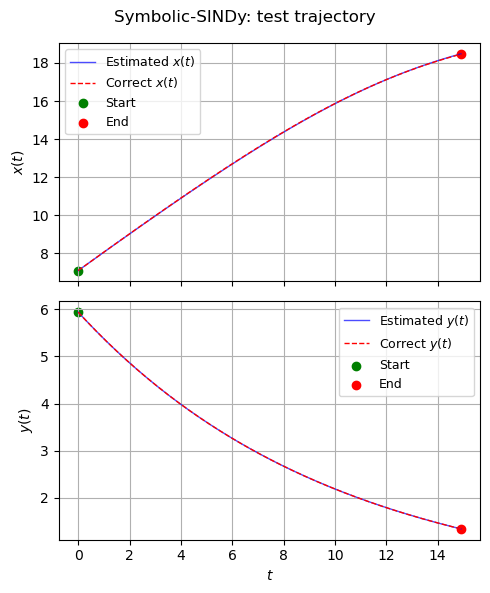

In [10]:
n_test = 10
rmse, _ = SINDy_data.evaluate_RMSE(final_model, ode, freq, n_test, [10., 10.], [0., 0.], dim_k)
print('Best SINDy Model RMSE: ', rmse)

evaluate_sample = 1
ics = [7., 6.]
title = 'Symbolic-SINDy: test trajectory'
evaluate_traj(final_model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=15)

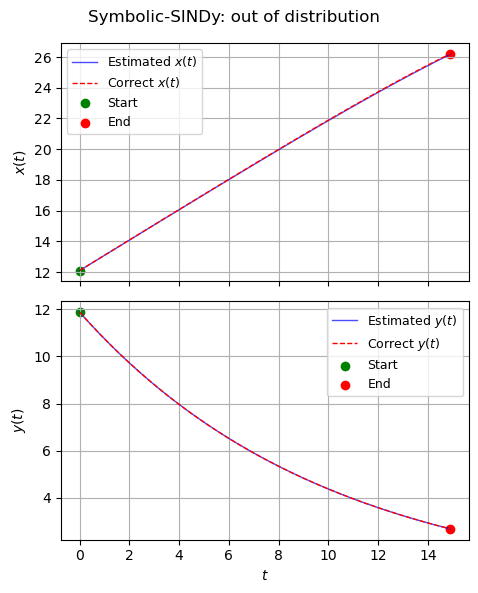

In [11]:
evaluate_sample = 1
ics = [12, 12]
title = 'Symbolic-SINDy: out of distribution'
evaluate_traj(final_model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=15)

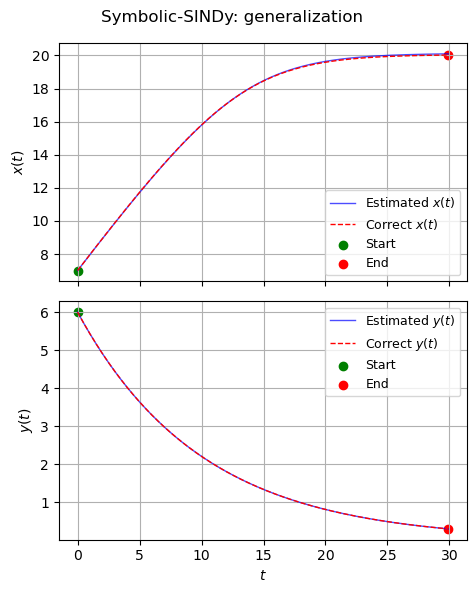

In [12]:
evaluate_sample = 1
ics = [7, 6]
title = 'Symbolic-SINDy: generalization'
evaluate_traj(final_model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=30)